# LURE THE CATS - Analysis 
Jason Müller (muellerj@tropos.de)

May 9, 2024

StuMeTa 2024 in Leipzig

---


## General Stuff

In [1]:
# Get relevant modules
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

plt.rcParams["figure.figsize"] = (15, 8) # set figsizes
plt.rcParams.update({'font.size': 18})   # set fontsizes
mpl.rcParams['lines.linewidth'] = 2.5

In [2]:
# Read in files as individual xarray datasets
infile = "./budget1000_rounds50.nc"
ds50 = xr.open_mfdataset(infile)

infile = "./budget1000_rounds100.nc"
ds100 = xr.open_mfdataset(infile)

infile = "./budget1000_rounds200.nc"
ds200 = xr.open_mfdataset(infile)

dset_list = [ds50, ds100, ds200]
dset_name_list = ["Budget: 50", "Budget: 100", "Budget: 200" ]   # for easier plotting later

total_budget = ds50.Total_Budget

OSError: no files to open

In [3]:
players = ds50.Players.values  # Get player names
cmap = plt.cm.viridis
p_colors = [cmap(x) for x in np.linspace(0, 1, len(players))] # Try to establish a consistent colorscheme for the notebook
lw = 2.5 # have a consistent linewidth for all the plots

In [4]:
ds = ds50 # Look at the Dataset

## Get an overview over the games 

Text(0.5, 1.0, '200 Round Game')

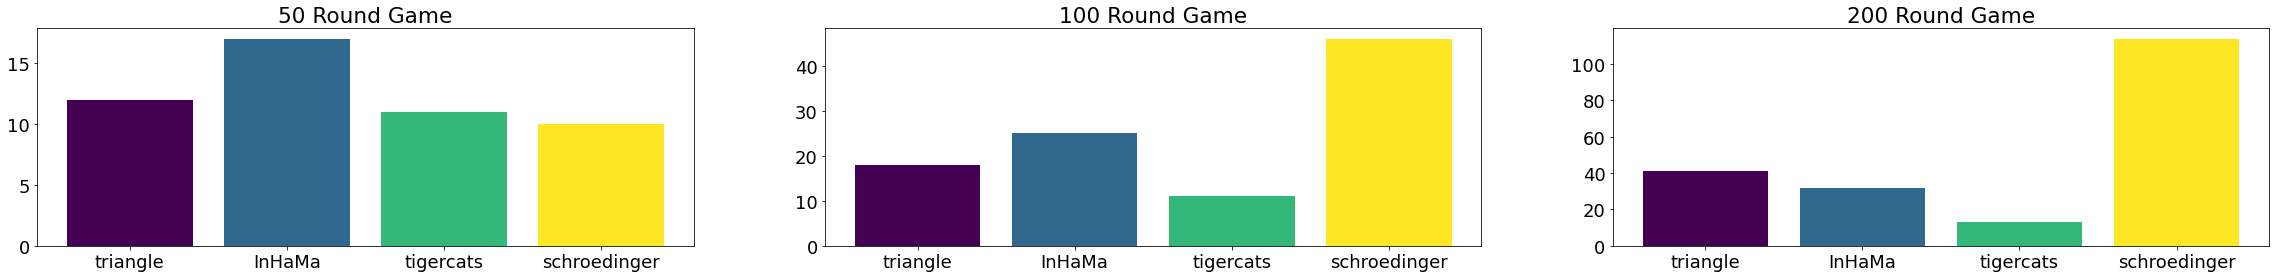

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(40, 4))  # 1 row, 3 columns

# Plotting each bar plot
axes[0].bar(players, ds50.wins.sel(Rounds = len(ds50.Rounds)-1), color = p_colors)
axes[0].set_title('50 Round Game')
axes[1].bar(players, ds100.wins.sel(Rounds = len(ds100.Rounds)-1), color = p_colors)
axes[1].set_title('100 Round Game')
axes[2].bar(players, ds200.wins.sel(Rounds = len(ds200.Rounds)-1), color = p_colors)
axes[2].set_title('200 Round Game')

## Overview over one specific game

In [6]:
ds = ds50 # Choose game

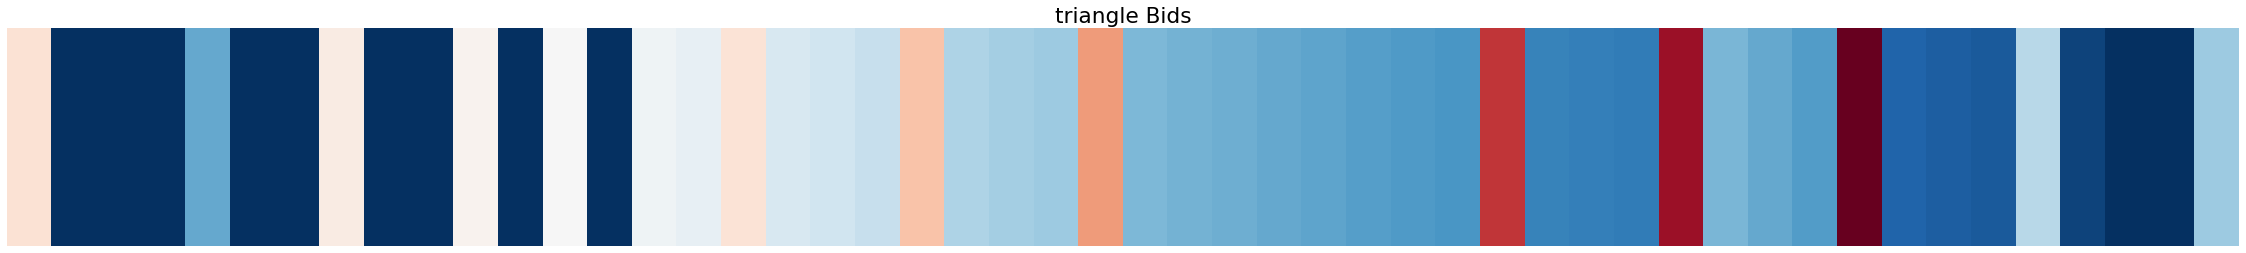

In [8]:
# Warming-stripes-style plot just for fun
player = "triangle"
plt.figure(figsize=(40, 4))  
plt.imshow(ds.bids.sel(Players = player).values.reshape(1, -1), cmap="RdBu_r", aspect='auto')
plt.axis('off')  # Turn off axis
plt.title(player +' Bids')
plt.show()

---
### Bids per Round

Text(0, 0.5, 'Bid')

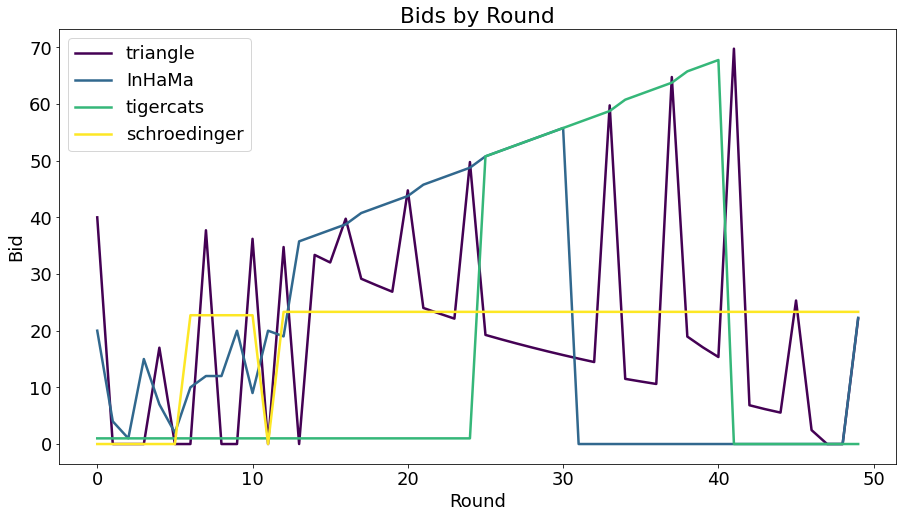

In [9]:
plt.title("Bids by Round")
for i in range(len(players)):
    plt.plot(ds.Rounds, ds.bids.sel(Players = players[i]), label=players[i], color = p_colors[i])
plt.legend()
plt.xlabel("Round")
plt.ylabel("Bid")

### Wins per round

Text(0, 0.5, 'Win count')

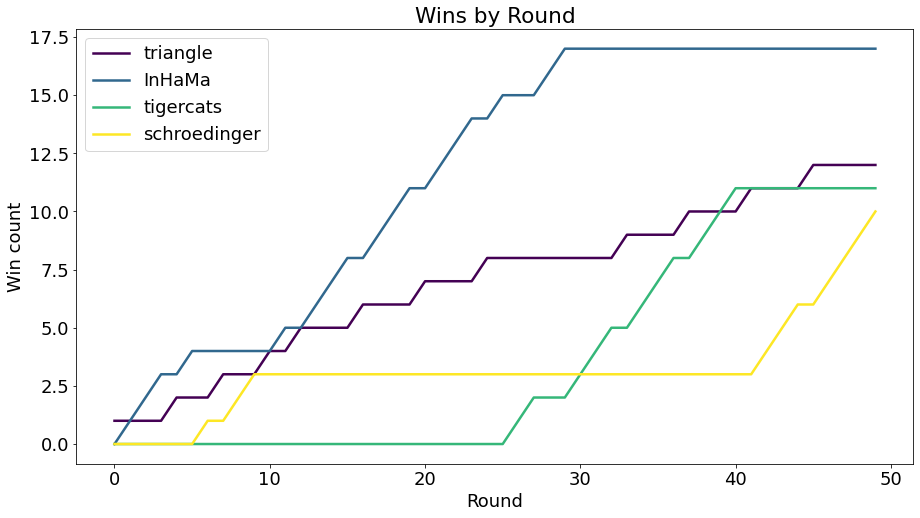

In [10]:
plt.title("Wins by Round")
for i in range(len(players)):
    plt.plot(ds.Rounds, ds.wins.sel(Players = players[i]), label=players[i], color = p_colors[i])
plt.legend()
plt.xlabel("Round")
plt.ylabel("Win count")

### Cat-Pricing per Round

Text(0, 0.5, 'Bid')

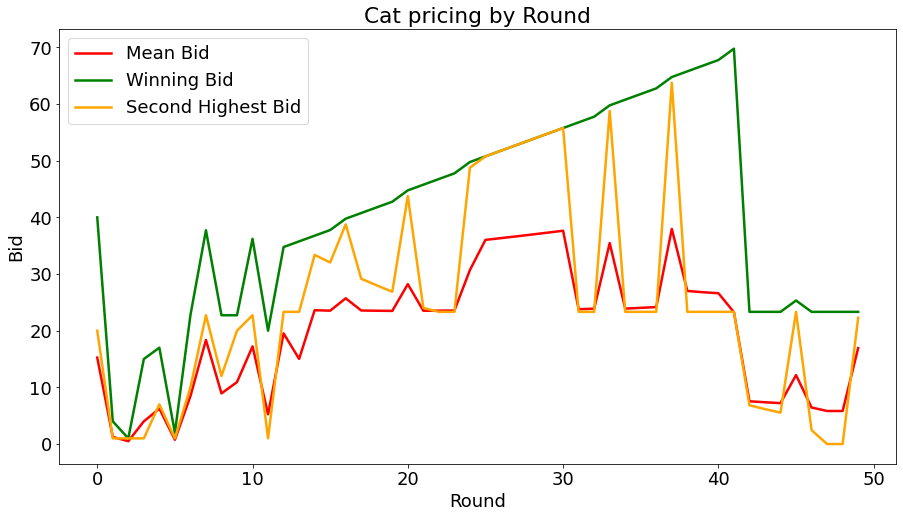

In [11]:
plt.title("Cat pricing by Round")

plt.plot(ds.Rounds, ds.bids.mean("Players"), color = "Red", label="Mean Bid")
plt.plot(ds.Rounds, ds.bids.max("Players"), color = "Green", label = "Winning Bid")

indices = np.argsort(ds.bids.values, axis=0)[-2, :]
second_largest_values = ds.bids.values[indices, np.arange(ds.bids.values.shape[1])]

plt.plot(ds.Rounds, second_largest_values , color = "Orange", label = "Second Highest Bid")
    
plt.legend()
plt.xlabel("Round")
plt.ylabel("Bid")

### Further ideas that may or may not be interesting
* Mean difference between the second highest and highest bid? 
* Amount of money lost by each player? Per Round?
* Deviation from mean price?
* Trends in the cat price?
* Average Overpay? Overpay by Player?


### Looking at my own algorythms

In [12]:
me = "triangle"  #choose your own algorythm

Text(0, 0.5, 'Bid')

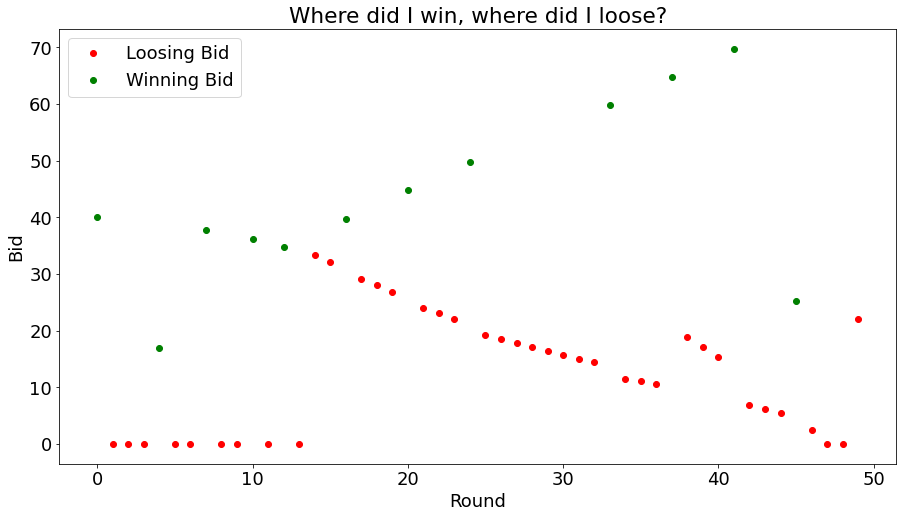

In [13]:
plt.title("Where did I win, where did I loose?")
lost_round_bids = ds.bids.sel(Players = me).where(ds.bids.sel(Players = me) != ds.bids.max("Players"), np.nan)   # mask all the rounds I lost
won_round_bids = ds.bids.sel(Players = me).where(ds.bids.sel(Players = me) == ds.bids.max("Players"), np.nan)    # mask all the rounds I won

plt.plot(ds.Rounds, lost_round_bids, color = "Red", label="Loosing Bid", marker = "o", linestyle = "")
plt.plot(ds.Rounds, won_round_bids, color = "Green", label="Winning Bid", marker = "o", linestyle = "")

    
plt.legend()
plt.xlabel("Round")
plt.ylabel("Bid")

(0.0, 1000.0)

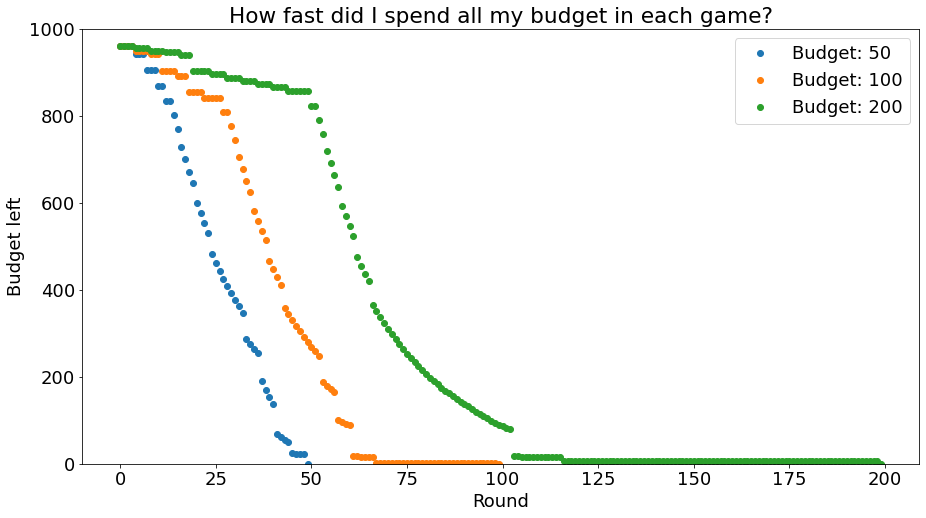

In [14]:
plt.title("How fast did I spend all my budget in each game?")
i = 0
for dset in dset_list:
    
    budget_left = dset.Total_Budget - np.cumsum(dset.bids.sel(Players = me))    # calculate what is left of my budget after each round
    plt.plot(dset.Rounds, budget_left, marker = "o", linestyle = "", label = dset_name_list[i])
    i += 1
plt.legend()
plt.xlabel("Round")
plt.ylabel("Budget left")
plt.ylim(0,1000)

In [24]:
def prepare_expenses_for_pie(dset):
    
    lost_round_bids = dset.bids.where(dset.bids.sel(Players = me) != dset.bids.max("Players"), np.nan)   # mask all the rounds I lost
    won_round_bids = dset.bids.where(dset.bids.sel(Players = me) == dset.bids.max("Players"), np.nan)    # mask all the rounds I won
    
    indices = np.argsort(won_round_bids.values, axis=0)[-2, :]
    second_largest_values = won_round_bids.values[indices, np.arange(won_round_bids.values.shape[1])]
    
    
    overpay = np.nansum(won_round_bids.sel(Players = me) - second_largest_values)
    underpay = np.nansum(lost_round_bids.sel(Players = me))
    
    money_well_spend = np.nansum(won_round_bids.sel(Players = me)) - overpay
    
    leftover_budget = total_budget - (overpay + underpay + money_well_spend )
    expenses = [overpay, underpay, money_well_spend, leftover_budget]
    
    return(np.absolute(expenses))

### Where did my budget go?

Text(0.5, 1.0, '200 Round Game')

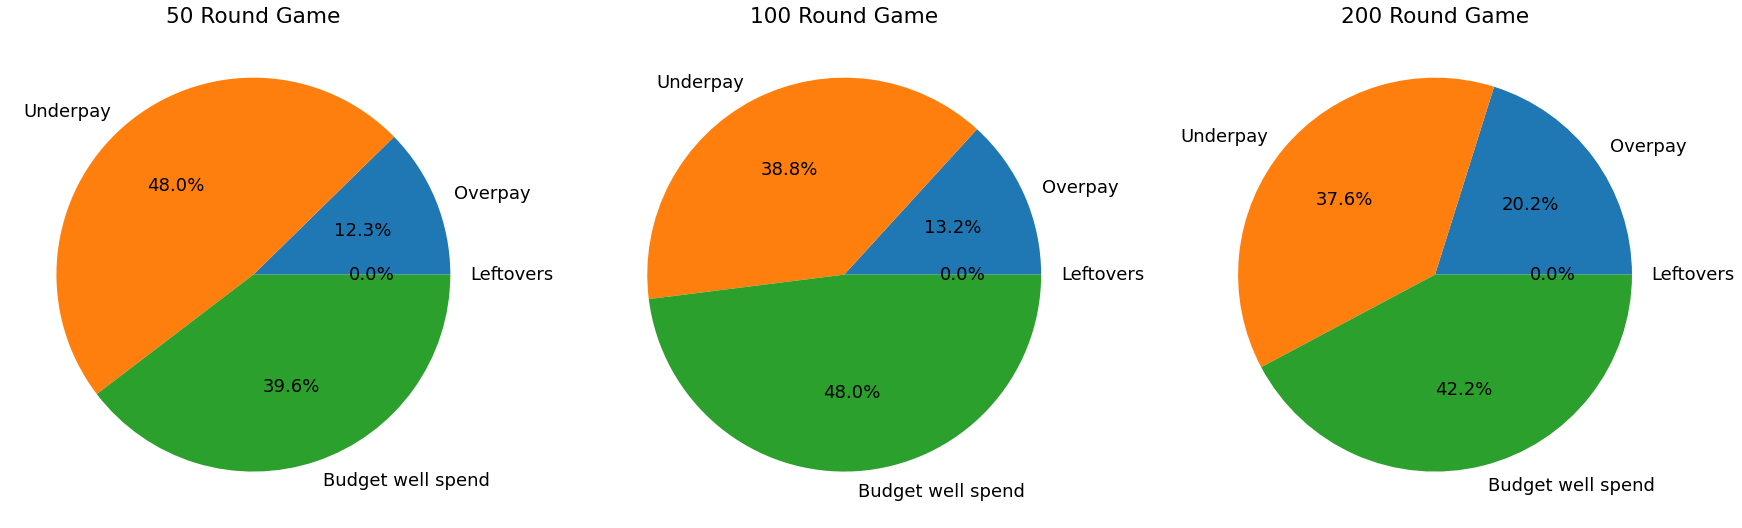

In [27]:
expens_labels = ["Overpay", "Underpay", "Budget well spend", "Leftovers"]

fig, axes = plt.subplots(1, 3, figsize=(30, 30))  # 1 row, 3 columns

axes[0].pie(prepare_expenses_for_pie(ds50), labels = expens_labels, autopct='%1.1f%%')
axes[0].set_title('50 Round Game')
axes[1].pie(prepare_expenses_for_pie(ds100), labels = expens_labels, autopct='%1.1f%%')
axes[1].set_title('100 Round Game')
axes[2].pie(prepare_expenses_for_pie(ds200), labels = expens_labels, autopct='%1.1f%%')
axes[2].set_title('200 Round Game')




### Trends 